In [8]:
import pandas as pd
import tqdm
import json
import glob
import tempfile
import subprocess
import os
from pathlib import Path
from dataclasses import dataclass


@dataclass
class Mutation:
    program_name: str
    program_source_before: str
    diff: str
    program_source_after: str
    operator_name: str
    job_id: str
    execution_result: dict
    mutation_object: dict
    result_object: dict


def apply_mutation(program_source: str, diff: str) -> str:
    """
    Applies diff to program_source by creating a temporary file and applying the diff to it.
    """
    # Write program_source to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, mode="w") as temp_file:
        temp_file.write(program_source)
        temp_file_path = temp_file.name

    # Write diff to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, mode="w") as diff_file:
        diff_file.write(diff)
        diff_file_path = diff_file.name

    # Apply the diff to the temporary file
    subprocess.run(
        f"patch -F 3 {temp_file_path} {diff_file_path}",
        shell=True,
        capture_output=True,
        check=True,
    )

    # Read the modified source code
    with open(temp_file_path, "r") as modified_file:
        modified_source = modified_file.read()

    # Clean up the temporary files
    os.remove(temp_file_path)
    os.remove(diff_file_path)

    return modified_source


def parse_output(results_data: dict) -> dict:
    """
    Parses the stdout of the execution of the mutation. Looks for the flags:
    - "UNCOMPILABLE MODEL"
    - "MODEL IS NOT BUGGY"
    - "Accuracy: XX"
    """
    output = results_data["output"].split(
        "=================================== FAILURES ==================================="
    )[0]

    if any(
        error in output
        for error in [
            "SyntaxError",
            "TypeError",
            "AttributeError",
            "IndexError",
            "rasp.py:388: AssertionError",
            "shuffle_dyck.py:100: AssertionError",
            "shuffle_dyck.py:95: AssertionError",
            "shuffle_dyck2.py:100: AssertionError",
            "shuffle_dyck2.py:95: AssertionError",
        ]
    ):
        return {"status": "FAILED_MUTATION"}
    elif "timeout" in output:
        return {"status": "TIMEOUT"}
    elif "TypeError" in output:
        return {"status": "TYPE_ERROR"}
    elif "UNCOMPILABLE MODEL" in output:
        return {"status": "UNCOMPILABLE_MODEL"}
    elif "MODEL IS NOT BUGGY" in output:
        return {"status": "CORRECT_MODEL"}
    elif "Accuracy: " in output:
        return {
            "status": "BUGGY_MODEL",
            "accuracy": float(output.split("Accuracy: ")[1].split("\n")[0]),
        }
    else:
        raise ValueError(f"Unknown output: {results_data["output"]}")


def process_mutation(mutation_data: tuple[dict, dict], program_name: str) -> Mutation:
    """
    Builds the mutation data structure from the mutation_data object.
    """
    # Read the program source code
    program_source = Path(f"source/{program_name}.py").read_text()
    # Apply the mutation to the program source code
    diff = mutation_data[1]["diff"]
    program_source_after = apply_mutation(program_source, diff)

    # Parse the output
    execution_result = parse_output(mutation_data[1])

    return Mutation(
        program_name=program_name,
        program_source_before=program_source,
        diff=diff,
        program_source_after=program_source_after,
        operator_name=mutation_data[0]["mutations"][0]["operator_name"],
        job_id=mutation_data[0]["job_id"],
        execution_result=execution_result,
        mutation_object=mutation_data[0],
        result_object=mutation_data[1],
    )


# Find all tracr_*.jsonl files in the results directory and its subdirectories
results_dir = Path("results")
mutation_files = glob.glob(str(results_dir / "**/tracr_*.jsonl"), recursive=True)

# Initialize an empty list to store all mutations
all_mutations = []

# Process each mutation file
for file_path in tqdm.tqdm(mutation_files):
    # Extract program name from the file path
    program_name = Path(file_path).parent.name

    # Read and process each line in the JSONL file
    with open(file_path, "r") as f:
        for line in tqdm.tqdm(f):
            mutation_data = json.loads(line)
            # mutation_data has two elements, the first is the mutation and the second is the execution result
            # we aggregate them
            all_mutations.append(process_mutation(mutation_data, program_name))

# Convert to DataFrame
df = pd.DataFrame(all_mutations)

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample of the data:")
display(df.head())

# Save the DataFrame to a JSON file
df.to_json("results/aggregated_mutations.json", index=False, indent=4)

11it [00:00, 91.31it/s]0:00<?, ?it/s]
107it [00:00, 141.94it/s]00<00:00,  8.12it/s]
53it [00:00, 98.96it/s] :00<00:01,  2.02it/s]
228it [00:02, 112.45it/s]01<00:01,  1.94it/s]
229it [00:02, 110.12it/s]03<00:02,  1.11s/it]
72it [00:00, 108.63it/s]:05<00:01,  1.46s/it]
100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

Dataset shape: (700, 9)

Columns: ['program_name', 'program_source_before', 'diff', 'program_source_after', 'operator_name', 'job_id', 'execution_result', 'mutation_object', 'result_object']

Sample of the data:


,program_name,program_source_before,diff,program_source_after,operator_name,job_id,execution_result,mutation_object,result_object
0,hist,"from tracr.rasp import rasp\n\n\ndef make_hist() -> rasp.SOp:\n """"""Returns the number of times each token occurs in the input.\n\n (As implemented in the RASP paper.)\n\n Example usage:\n hist = make_hist()\n hist(""abac"")\n >> [2, 1, 2, 1]\n """"""\n same_tok = rasp.Select(rasp.tokens, rasp.tokens, rasp.Comparison.EQ).named(\n ""same_tok""\n )\n return rasp.SelectorWidth(same_tok).named(""hist"")\n","--- mutation diff ---\n--- asource/hist.py\n+++ bsource/hist.py\n@@ -11,7 +11,7 @@\n hist(""abac"")\n >> [2, 1, 2, 1]\n """"""\n- same_tok = rasp.Select(rasp.tokens, rasp.tokens, rasp.Comparison.EQ).named(\n+ same_tok = rasp.Select(rasp.tokens, rasp.tokens, rasp.Comparison.LT).named(\n ""same_tok""\n )\n return rasp.SelectorWidth(same_tok).named(""hist"")","from tracr.rasp import rasp\n\n\ndef make_hist() -> rasp.SOp:\n """"""Returns the number of times each token occurs in the input.\n\n (As implemented in the RASP paper.)\n\n Example usage:\n hist = make_hist()\n hist(""abac"")\n >> [2, 1, 2, 1]\n """"""\n same_tok = rasp.Select(rasp.tokens, rasp.tokens, rasp.Comparison.LT).named(\n ""same_tok""\n )\n return rasp.SelectorWidth(same_tok).named(""hist"")\n",operators/replace-rasp-comparison,4877157928854d51aa44ea18a425e1cb,"{'status': 'BUGGY_MODEL', 'accuracy': 0.0}","{'job_id': '4877157928854d51aa44ea18a425e1cb', 'mutations': [{'module_path': 'source/hist.py', 'operator_name': 'operators/replace-rasp-comparison', 'occurrence': 0, 'start_pos': [14, 53], 'end_pos': [14, 71], 'operator_args': {}}]}","{'worker_outcome': 'normal', 'output': '============================= test session starts ============================== platform linux -- Python 3.12.7, pytest-8.3.3, pluggy-1.5.0 rootdir: /home/andre/Repos/RASPing/experiments/mutation plugins: anyio-4.4.0 collected 3 items tests/test_hist.py ssAccuracy: 0.0 F =================================== FAILURES =================================== _____________________________ TestHist.test_model ______________________________ self = <tests.test_hist.TestHist object at 0x752dd2c50110> def test_model(self): > self.test() tests/test_hist.py:21: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ self = <tests.test_hist.TestHist object at 0x752dd2c50110> @pytest.mark.skip(reason=""This is not a test"") def test(self): try: model = Model(self.model, self.inputs, self.maxLength, self.name) except Exception as e: # Survive if the model is not compilable (we want to kill the buggy ones) print(str(e)) # Print message for post-processing print(""UNCOMPILABLE MODEL"") return accuracy = model.evaluateModel( self.testing_data, doPrint=False, outputArray=False, useAssert=False ) # Print the accuracy for post-processing print(""Accuracy: "", accuracy) > assert accuracy == 1.0 E AssertionError tests/test.py:45: AssertionError =========================== short test summary info ============================ FAILED tests/test_hist.py::TestHist::test_model - AssertionError ======================== 1 failed, 2 skipped in 28.73s ========================= ', 'test_outcome': 'killed', 'diff': '--- mutation diff --- --- asource/hist.py +++ bsource/hist.py @@ -11,7 +11,7 @@ hist(""abac"") >> [2, 1, 2, 1] """""" - same_tok = rasp.Select(rasp.tokens, rasp.tokens, rasp.Comparison.EQ).named( + same_tok = rasp.Select(rasp.tokens, rasp.tokens, rasp.Comparison.LT).named( ""same_tok"" ) return rasp.SelectorWidth(same_tok).named(""hist"")'}"
1,hist,"from tracr.rasp import rasp\n\n\ndef make_hist() -> rasp.SOp:\n """"""Returns the number of times each token occurs in the input.\n\n (As implemented in the RASP paper.)\n\n Example usage:\n hist = make_hist()\n hist(""abac"")\n >> [2, 1, 2, 1]\n """"""\n same_tok = rasp.Select(rasp.tokens, rasp.tokens, rasp.Comparison.EQ).named(\n ""same_tok""\n )\n return rasp.SelectorWidth(same_tok).named(""hist"")\n","--- muta

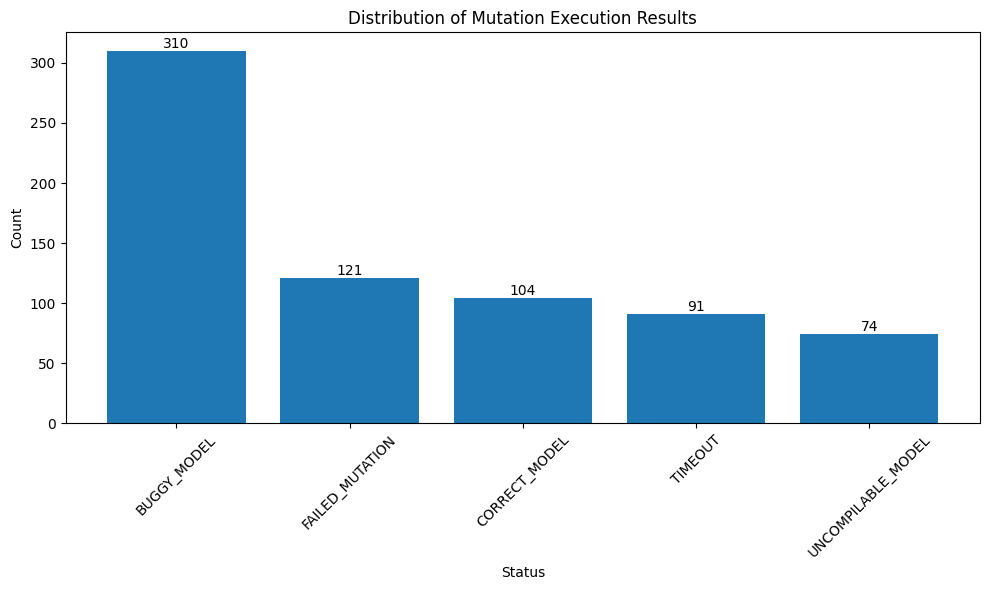

In [9]:
# Create a bar plot of execution results
import matplotlib.pyplot as plt

# Count the different status types
status_counts = df["execution_result"].apply(lambda x: x["status"]).value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(status_counts.index, status_counts.values)

# Customize the plot
plt.title("Distribution of Mutation Execution Results")
plt.xlabel("Status")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(status_counts.values):
    plt.text(i, v, str(v), ha="center", va="bottom")

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

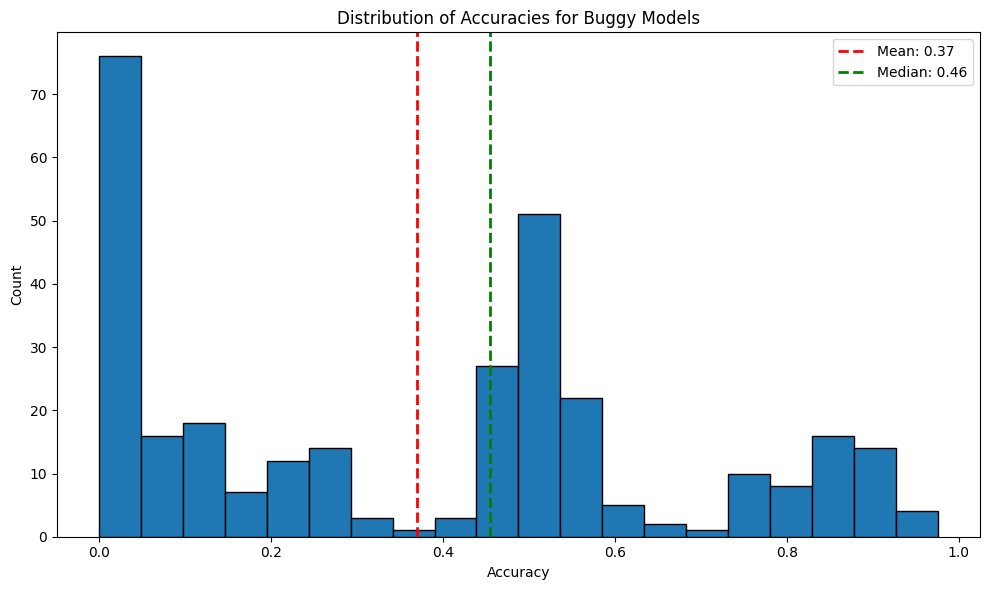

Number of buggy models: 310
Mean accuracy: 0.37
Median accuracy: 0.46
Min accuracy: 0.00
Max accuracy: 0.98


In [10]:
# Filter for only BUGGY_MODEL results and extract accuracies
buggy_models = df[df["execution_result"].apply(lambda x: x["status"] == "BUGGY_MODEL")]
accuracies = buggy_models["execution_result"].apply(lambda x: x["accuracy"])

# Create histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=20, edgecolor="black")

# Customize the plot
plt.title("Distribution of Accuracies for Buggy Models")
plt.xlabel("Accuracy")
plt.ylabel("Count")

# Add summary statistics
plt.axvline(
    accuracies.mean(),
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Mean: {accuracies.mean():.2f}",
)
plt.axvline(
    accuracies.median(),
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Median: {accuracies.median():.2f}",
)

plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Number of buggy models: {len(accuracies)}")
print(f"Mean accuracy: {accuracies.mean():.2f}")
print(f"Median accuracy: {accuracies.median():.2f}")
print(f"Min accuracy: {accuracies.min():.2f}")
print(f"Max accuracy: {accuracies.max():.2f}")

In [11]:
# Create a summary table by program
summary = []
for program in df["program_name"].unique():
    program_data = df[df["program_name"] == program]
    total = len(program_data)

    # Count different status types
    status_counts = (
        program_data["execution_result"].apply(lambda x: x["status"]).value_counts()
    )

    # Calculate mean accuracy for buggy models
    buggy_models = program_data[
        program_data["execution_result"].apply(lambda x: x["status"] == "BUGGY_MODEL")
    ]
    mean_accuracy = (
        buggy_models["execution_result"].apply(lambda x: x["accuracy"]).mean()
    )

    summary.append(
        {
            "Program": program,
            "Total Mutations": total,
            "Failed Mutations": f"{status_counts.get('FAILED_MUTATION', 0)} ({status_counts.get('FAILED_MUTATION', 0)/total*100:.1f}%)",
            "Uncompilable": f"{status_counts.get('UNCOMPILABLE_MODEL', 0)} ({status_counts.get('UNCOMPILABLE_MODEL', 0)/total*100:.1f}%)",
            "Correct Models": f"{status_counts.get('CORRECT_MODEL', 0)} ({status_counts.get('CORRECT_MODEL', 0)/total*100:.1f}%)",
            "Buggy Models": f"{status_counts.get('BUGGY_MODEL', 0)} ({status_counts.get('BUGGY_MODEL', 0)/total*100:.1f}%)",
            "Timeouts": f"{status_counts.get('TIMEOUT', 0)} ({status_counts.get('TIMEOUT', 0)/total*100:.1f}%)",
            "Mean Accuracy (Buggy)": (
                f"{mean_accuracy:.2f}" if not pd.isna(mean_accuracy) else "N/A"
            ),
        }
    )

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values("Total Mutations", ascending=False)

# Calculate totals
total_mutations = df.shape[0]
total_status_counts = df["execution_result"].apply(lambda x: x["status"]).value_counts()
total_buggy = df[df["execution_result"].apply(lambda x: x["status"] == "BUGGY_MODEL")]
total_mean_accuracy = (
    total_buggy["execution_result"].apply(lambda x: x["accuracy"]).mean()
)

# Add total row
total_row = pd.DataFrame(
    [
        {
            "Program": "TOTAL",
            "Total Mutations": total_mutations,
            "Failed Mutations": f"{total_status_counts.get('FAILED_MUTATION', 0)} ({total_status_counts.get('FAILED_MUTATION', 0)/total_mutations*100:.1f}%)",
            "Uncompilable": f"{total_status_counts.get('UNCOMPILABLE_MODEL', 0)} ({total_status_counts.get('UNCOMPILABLE_MODEL', 0)/total_mutations*100:.1f}%)",
            "Correct Models": f"{total_status_counts.get('CORRECT_MODEL', 0)} ({total_status_counts.get('CORRECT_MODEL', 0)/total_mutations*100:.1f}%)",
            "Buggy Models": f"{total_status_counts.get('BUGGY_MODEL', 0)} ({total_status_counts.get('BUGGY_MODEL', 0)/total_mutations*100:.1f}%)",
            "Timeouts": f"{total_status_counts.get('TIMEOUT', 0)} ({total_status_counts.get('TIMEOUT', 0)/total_mutations*100:.1f}%)",
            "Mean Accuracy (Buggy)": (
                f"{total_mean_accuracy:.2f}"
                if not pd.isna(total_mean_accuracy)
                else "N/A"
            ),
        }
    ]
)

# Combine summary and total
summary_df = pd.concat([summary_df, total_row])

# Display the table with better formatting
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
display(summary_df)

,Program,Total Mutations,Failed Mutations,Uncompilable,Correct Models,Buggy Models,Timeouts,Mean Accuracy (Buggy)
4,shuffle_dyck2,229,44 (19.2%),25 (10.9%),18 (7.9%),82 (35.8%),60 (26.2%),0.63
3,shuffle_dyck,228,38 (16.7%),21 (9.2%),72 (31.6%),86 (37.7%),11 (4.8%),0.57
1,most_freq,107,17 (15.9%),14 (13.1%),6 (5.6%),52 (48.6%),18 (16.8%),0.15
5,sort,72,10 (13.9%),13 (18.1%),6 (8.3%),43 (59.7%),0 (0.0%),0.09
2,reverse,53,12 (22.6%),1 (1.9%),2 (3.8%),36 (67.9%),2 (3.8%),0.04
0,hist,11,0 (0.0%),0 (0.0%),0 (0.0%),11 (100.0%),0 (0.0%),0.02
0,TOTAL,700,121 (17.3%),74 (10.6%),104 (14.9%),310 (44.3%),91 (13.0%),0.37


In [18]:
# Filter df for buggy_models
buggy_models = df[df["execution_result"].apply(lambda x: x["status"] == "BUGGY_MODEL")]

# Get one buggy model for each program
for program in buggy_models["program_name"].unique():
    program_data = buggy_models[buggy_models["program_name"] == program]
    print(program_data.iloc[0]["program_name"], program_data.iloc[0]["job_id"])

hist 4877157928854d51aa44ea18a425e1cb
most_freq 522c0475818042c4bead3e467f62aefb
reverse 2564f0095e7d430d88cb958a8e948972
shuffle_dyck 0025d214e8ad403f9771a909c9679d65
shuffle_dyck2 6bb5a25d429243a9b199efb4d54cc1f0
sort 5f1e78eb029f49b693b2653592dd7dea
